In [1]:
# Built-in
import os
import math
import itertools
import multiprocessing
import statistics

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.cluster as clustering
from tslearn.clustering import KShape
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

# Overhead

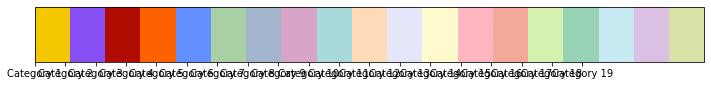

In [4]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

In [5]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

In [6]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [7]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [8]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [9]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [10]:
lump_excitatory = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','L5/6-IT','L5-PT']
lump_cin = ['CIN-PV','CIN-SST','CIN-VIP']

In [11]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [20]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

,id,name,color
1,1,L6-CT,#A9CFA4
7,7,L5-PT,#F4C700
2,2,L4/5-IT,#8650F5
3,3,L4-IT,#8650F5
0,0,L2/3-IT,#8650F5
5,5,L5/6-IT,#8650F5
11,12,CIN-VIP,#648FFF
8,8,CIN-PV,#B00B00
10,10,CIN-SST,#FE6100
4,4,Oligodendrocytes,#A3B5CC


In [14]:
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

In [15]:
def process_combination(drug, cluster, time):
    subset_memento = pd.read_excel(
        os.path.join(settings.data_path, f"memento_initial_DE_{drug}_{time}h.xlsx"),
        sheet_name=f'Cluster {cluster}',
        index_col=0
    )
    subset_memento = subset_memento.reset_index(drop=True)
    subset_memento = subset_memento[['gene', 'de_coef', 'de_se', 'de_pval', 'de_pval_adj']]
    
    subset_memento['drug'] = drug
    subset_memento['cluster'] = cluster
    subset_memento['time'] = time
    return subset_memento

In [16]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_combination(drug,cluster,time) 
    for drug,cluster,time
    in progressbar_product(trt_drugs,clusters,trt_times)
#     if not (cluster=='4' and drug=='Psilo')
]
memento_full = pd.concat(combination_mementos)
print(memento_full.shape)
memento_full.head()

  0%|          | 0/120 [00:00<?, ?it/s]

(1412444, 8)


,gene,de_coef,de_se,de_pval,de_pval_adj,drug,cluster,time
0,Prrc2b,0.162677,0.015609,4.414582e-10,0.000005,Ket,0,1
1,Slc4a4,-0.124186,0.011237,1.556089e-09,0.000010,Ket,0,1
2,Map4,-0.179530,0.017800,4.780192e-08,0.000198,Ket,0,1
3,Maml3,0.218901,0.012652,7.577917e-08,0.000236,Ket,0,1
4,Btg2,-0.846753,0.069693,6.139451e-06,0.001071,Ket,0,1


In [61]:
def process_IT_combination(drug, time):
    combination_memento = pd.read_excel(
        os.path.join(settings.fig_path, f"figure_4/memento_DE_{drug}_{time}h.xlsx"),
    )
    combination_memento = combination_memento[['gene', 'de_coef', 'de_se', 'de_pval', 'de_pval_adj']]    
    combination_memento['drug'] = drug
    combination_memento['time'] = time
    return combination_memento

In [62]:
from tqdm.contrib.itertools import product as progressbar_product
combination_mementos = [
    process_IT_combination(drug,time) 
    for drug,time
    in progressbar_product(trt_drugs,trt_times)
]
memento_IT = pd.concat(combination_mementos)
print(memento_IT.shape)
memento_IT.head()

  0%|          | 0/10 [00:00<?, ?it/s]

(126472, 7)


,gene,de_coef,de_se,de_pval,de_pval_adj,drug,time
0,Lpgat1,0.123609,0.008061,1.527522e-10,0.000002,Ket,1
1,Mkx,-0.108052,0.006298,2.079828e-09,0.000013,Ket,1
2,Lrrc49,0.152214,0.009209,5.000465e-09,0.000016,Ket,1
3,Tesc,0.220526,0.025597,4.714644e-09,0.000016,Ket,1
4,Mapk11,0.208848,0.015645,9.215292e-09,0.000023,Ket,1


# fig S1b -  Num DE genes (memento and IT lump)

In [53]:
num_de_df = memento_full.merge(cluster_lookup, how='left', left_on='cluster', right_on='id')
num_de_df = num_de_df[(num_de_df['name'].isin(['L5-PT','CIN-VIP','CIN-PV','CIN-SST'])) &
                      (num_de_df['de_pval_adj'] < 0.05)]
num_de_df['name'] = num_de_df['name'].cat.remove_unused_categories()
num_de_df = num_de_df.groupby(['drug','time','name']).size().reset_index(name='num_memento_deg')

In [65]:
num_it_de_df = memento_IT.assign(name='IT')
num_it_de_df = num_it_de_df[num_it_de_df['de_pval_adj'] < 0.05]
num_it_de_df = num_it_de_df.groupby(['drug','time','name']).size().reset_index(name='num_memento_deg')
num_it_de_df

,drug,time,name,num_memento_deg
0,Ket,1,IT,7554
1,Ket,2,IT,8410
2,Ket,4,IT,9038
3,Ket,24,IT,5307
4,Ket,72,IT,7929
5,Psilo,1,IT,10370
6,Psilo,2,IT,6374
7,Psilo,4,IT,7271
8,Psilo,24,IT,6791
9,Psilo,72,IT,8776


In [68]:
joined_num_des = pd.concat([num_de_df, num_it_de_df]).reset_index(drop=True)
joined_num_des.to_csv(f'{settings.fig_path}/memento_num_de_genes.csv', index=False)

<AxesSubplot: xlabel='time', ylabel='num_memento_deg'>

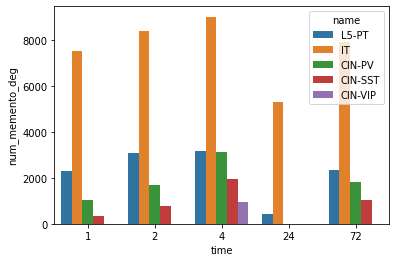

In [71]:
sns.barplot(data=joined_num_des.query('drug == "Ket"'), 
            x='time', y='num_memento_deg', 
            hue='name', hue_order=['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP'])